In [1]:
# Librerias
from datetime import date, datetime
from sqlalchemy import create_engine
import re
import os
import smtplib
import time
import configparser
# Manipulacion y tratamiento de datos
import numpy as np
import pandas as pd

# Graficos
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import hvplot.pandas
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
import plotly.graph_objects as go

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams["figure.figsize"] = (12, 8)
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

In [2]:
# Modelacion Arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Auto Arima

from pmdarima import auto_arima

# Metrica de evaluacion
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

In [3]:
# Evaluaciones de Modelos

def evaluacion_metricas(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true-y_pred)/y_true)) *100
    print('Evaluación de las metricas resultados:-')
    print(f'MSE es: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE es: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE es: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE es: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R^2 es: {metrics.r2_score(y_true, y_pred)}', end = '\n\n')

# Modelo Para los Refunds

In [4]:
refunds2 = pd.read_excel('Datos de refunds y ventas.xlsx', sheet_name='Refunds')
refunds2['Fecha'] = pd.to_datetime(refunds2['Fecha'])
refunds2 = refunds2.set_index('Fecha')
refunds2 = refunds2.drop(['Amazon','eBay','Shopify','Walmart', 'Google'], axis= 1)
refunds2.head()

,Total
Fecha,
2020-01-01,421.27
2020-01-02,5546.81
2020-01-03,7327.57
2020-01-04,2726.78
2020-01-05,1101.16


In [5]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

tss = TimeSeriesSplit(n_splits=5, test_size= 32, gap =7)
tss

TimeSeriesSplit(gap=7, max_train_size=None, n_splits=5, test_size=32)

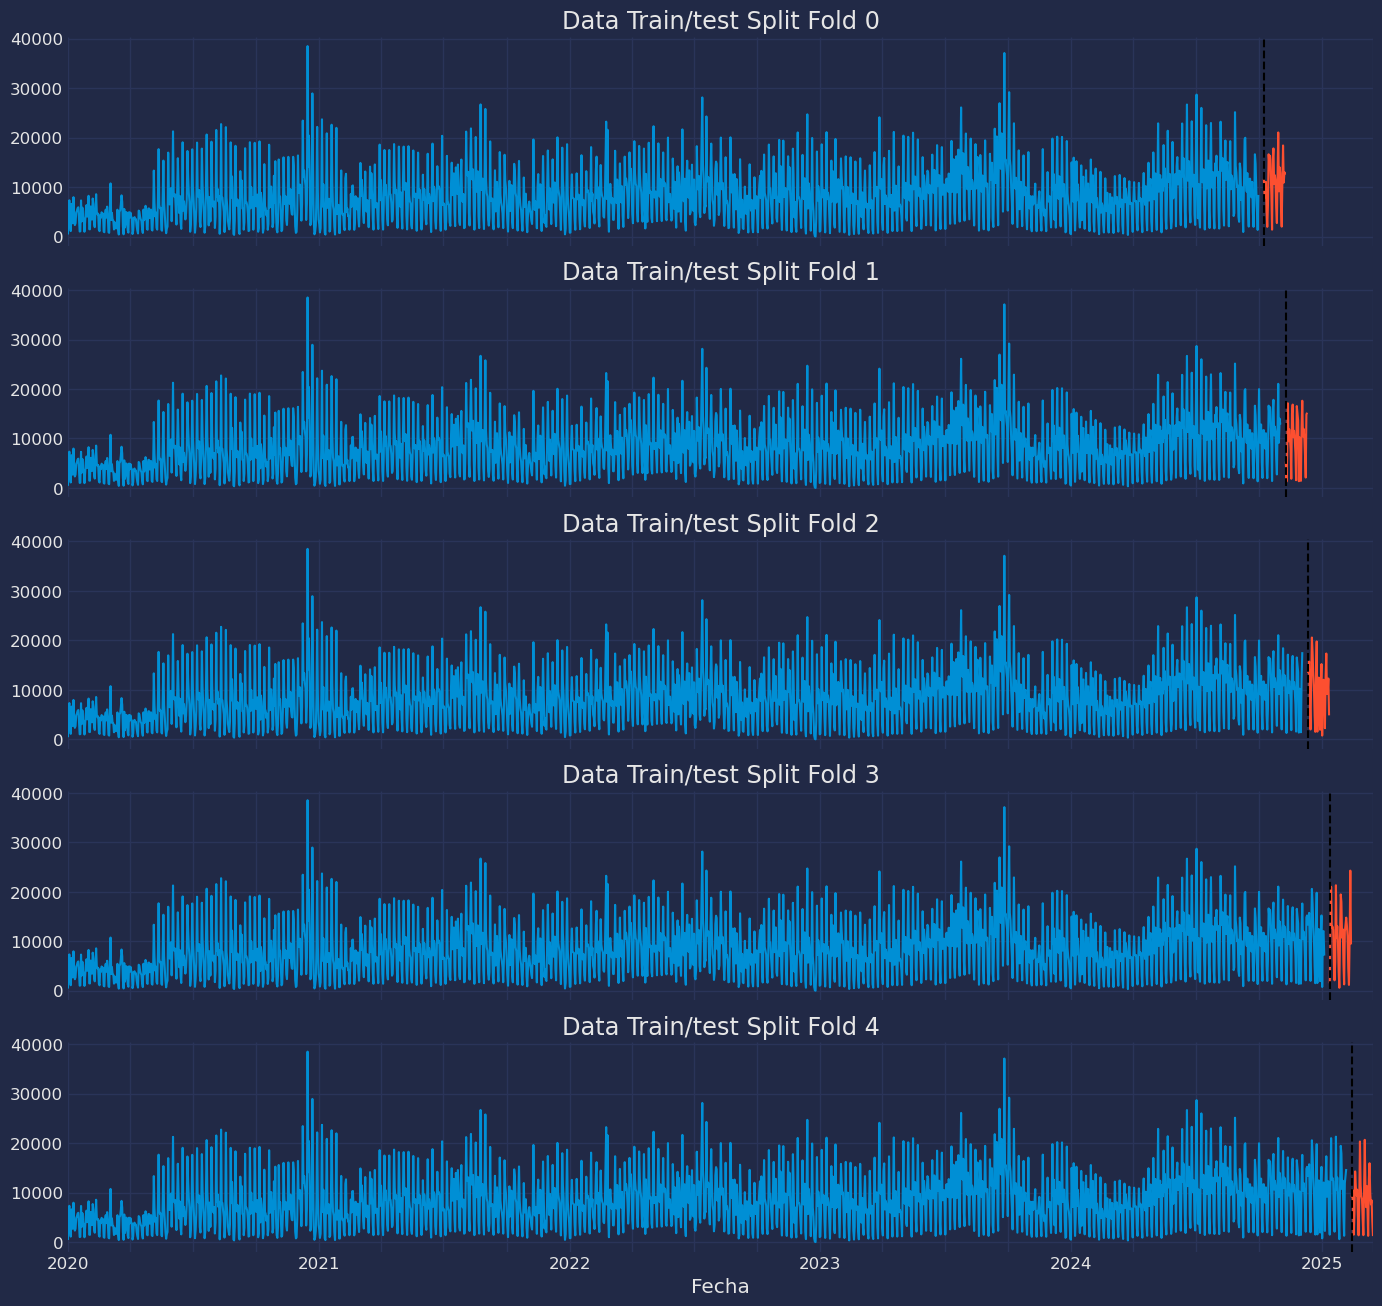

In [6]:
fig, axs = plt.subplots(5,1,figsize =(15,15), sharex=True)
fold = 0

for train_idx, val_idx in tss.split(refunds2):
    train_1 = refunds2.iloc[train_idx]
    test_1 = refunds2.iloc[val_idx]
    train_1['Total'].plot(ax=axs[fold], 
                          label = 'Training Set',
                          title = f'Data Train/test Split Fold {fold}')
    test_1['Total'].plot(ax=axs[fold], 
                          label = 'Test Set')
    axs[fold].axvline(test_1.index.min(), color ='black', ls='--')
    fold +=1
plt.show()

In [7]:
def create_feature(df):
    df = df.copy()  

    df['Año'] = df.index.year
    df['Mes'] = df.index.month
    df['Dia'] = df.index.day
    df['Dia_de_la_Semana'] = df.index.dayofweek
    df['Trimestre'] = df.index.quarter
    df['semana_del_año'] = df.index.isocalendar().week
    df['Dia_del_año'] = df.index.dayofyear
    return df
refunds2 = create_feature(refunds2)

In [8]:
def add_lags(df):
    target_map = df.Total.to_dict()
    df['lag1'] = (df.index - pd.Timedelta('32 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('64 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('96 days')).map(target_map)
    return df

In [9]:
refunds2 = add_lags(refunds2)

In [10]:
refunds2.tail()

,Total,Año,Mes,Dia,Dia_de_la_Semana,Trimestre,semana_del_año,Dia_del_año,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2025-03-12,9847.76,2025,3,12,2,1,11,71,4469.93,17344.18,10188.92
2025-03-13,7609.64,2025,3,13,3,1,11,72,1167.22,9178.43,6489.20
2025-03-14,8438.36,2025,3,14,4,1,11,73,10836.20,9382.72,2092.97
2025-03-15,4232.92,2025,3,15,5,1,11,74,24271.03,12292.95,14827.47
2025-03-16,1206.46,2025,3,16,6,1,11,75,9361.96,4838.87,15216.88


In [11]:
### Entrenamiento

tss = TimeSeriesSplit(n_splits=5, test_size= 32, gap =7)
refunds2 = refunds2.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(refunds2):
    train_1 = refunds2.iloc[train_idx]
    test_1 = refunds2.iloc[val_idx]

    train_1 = create_feature(train_1)
    test_1 = create_feature(test_1)

    Feature = ['Año', 'Mes', 'Dia', 'Dia_de_la_Semana', 'Trimestre',
       'semana_del_año', 'Dia_del_año','lag1','lag2','lag3']
    Target = 'Total'

    X_train = train_1[Feature]
    y_train = train_1[Target]

    X_test = test_1[Feature]
    y_test = test_1[Target]

    X_train = X_train.astype(float)
    y_train = y_train.astype(float)
    X_test = X_test.astype(float)
    y_test = y_test.astype(float)

    
reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', n_estimators = 1000, 
                        early_stopping_rounds = 50, objective = 'reg:linear', 
                        max_depth = 3, learning_rate = 0.1)

reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

xgb_predictions = reg.predict(X_test)
preds.append(xgb_predictions)
score = np.sqrt(mean_squared_error(y_test, xgb_predictions))
scores.append(score)

[11:16:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9014.30643	validation_1-rmse:9038.49327
[100]	validation_0-rmse:2522.65861	validation_1-rmse:1788.86449
[149]	validation_0-rmse:2399.89241	validation_1-rmse:1806.88255


In [12]:
xgb_predictions

array([10159.424 , 11160.784 ,  6967.2   ,  2451.1597,  9676.98  ,
       16571.375 , 10066.426 , 10281.91  ,  9780.021 ,  4225.1035,
        1911.7722,  9676.98  , 16550.873 , 10106.794 ,  9778.527 ,
       11036.667 ,  4827.086 ,  2257.9255,  9443.97  , 17385.314 ,
       10791.234 ,  9716.0625, 11053.854 ,  4579.0654,  2344.3853,
        9676.98  , 16678.307 , 10791.234 , 10219.786 , 10950.65  ,
        3486.1526,  1862.0598], dtype=float32)

In [13]:
scores

[1785.1102708919568]

In [14]:
### Predicting the future
refunds2 = create_feature(refunds2)

Feature = ['Año', 'Mes', 'Dia', 'Dia_de_la_Semana', 'Trimestre',
       'semana_del_año', 'Dia_del_año','lag1','lag2','lag3']
Target = 'Total'

X_all = refunds2[Feature]
y_all = refunds2[Target]


reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', n_estimators = 500, 
                        early_stopping_rounds = 50, objective = 'reg:linear', 
                        max_depth = 3, learning_rate = 0.1)

reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[11:16:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9014.30643	validation_1-rmse:9038.49327
[100]	validation_0-rmse:2522.65861	validation_1-rmse:1788.86449
[149]	validation_0-rmse:2399.89241	validation_1-rmse:1806.88255


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [15]:
refunds2.index.max()

Timestamp('2025-03-16 00:00:00')

### Prediccion

In [16]:
# Fechas a predecir

future = pd.date_range('2025-03-17','2025-04-06', freq='1D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
refunds2['isFuture'] = False
df_and_future = pd.concat([refunds2, future_df])
df_and_future = create_feature(df_and_future)
df_and_future = add_lags(df_and_future)

In [17]:
future_w_feature =df_and_future.query('isFuture').copy()

In [18]:
#Prediction 

future_w_feature['refunds_pred']= reg.predict(future_w_feature[Feature].astype(float))

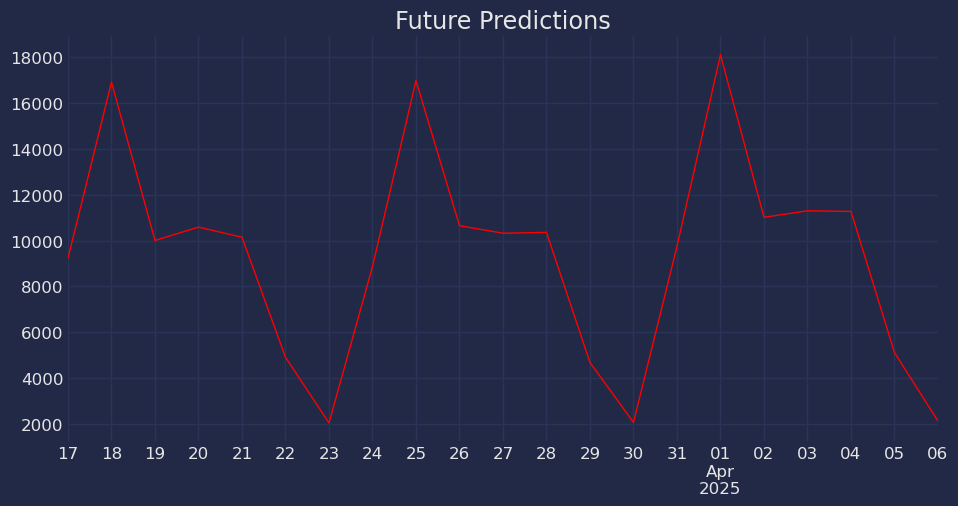

In [19]:
future_w_feature['refunds_pred'].plot(figsize=(10,5),
                              color = 'red',
                              ms = 1,
                              lw = 1,
                              title ='Future Predictions')
plt.show()

In [20]:
future_w_feature['refunds_pred']

2025-03-17     9226.793945
2025-03-18    16903.173828
2025-03-19    10003.185547
2025-03-20    10583.798828
2025-03-21    10144.034180
2025-03-22     4912.491211
2025-03-23     2051.258057
2025-03-24     8863.654297
2025-03-25    16973.496094
2025-03-26    10648.269531
2025-03-27    10318.463867
2025-03-28    10354.522461
2025-03-29     4683.175293
2025-03-30     2073.641357
2025-03-31     9747.570312
2025-04-01    18096.189453
2025-04-02    11012.904297
2025-04-03    11295.513672
2025-04-04    11267.114258
2025-04-05     5116.151367
2025-04-06     2133.336182
Name: refunds_pred, dtype: float32

In [21]:
fig = px.line(future_w_feature, x=future_w_feature.index, y ='refunds_pred', template='plotly_dark', title='Predicciones con el modelo de XGBoost')
fig.show()

# Modelo para ventas

In [22]:
ventas = pd.read_excel('Datos de refunds y ventas.xlsx', sheet_name='Ventas')
ventas = ventas[['Fecha', 'Total']]
ventas['Fecha'] = pd.to_datetime(ventas['Fecha'])
ventas = ventas.set_index('Fecha')
ventas.head()

,Total
Fecha,
2020-01-01,114838.8201
2020-01-02,132846.9601
2020-01-03,130644.7101
2020-01-04,120840.9203
2020-01-05,129750.7500


In [23]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

tss = TimeSeriesSplit(n_splits=5, test_size= 32, gap =7)
tss

TimeSeriesSplit(gap=7, max_train_size=None, n_splits=5, test_size=32)

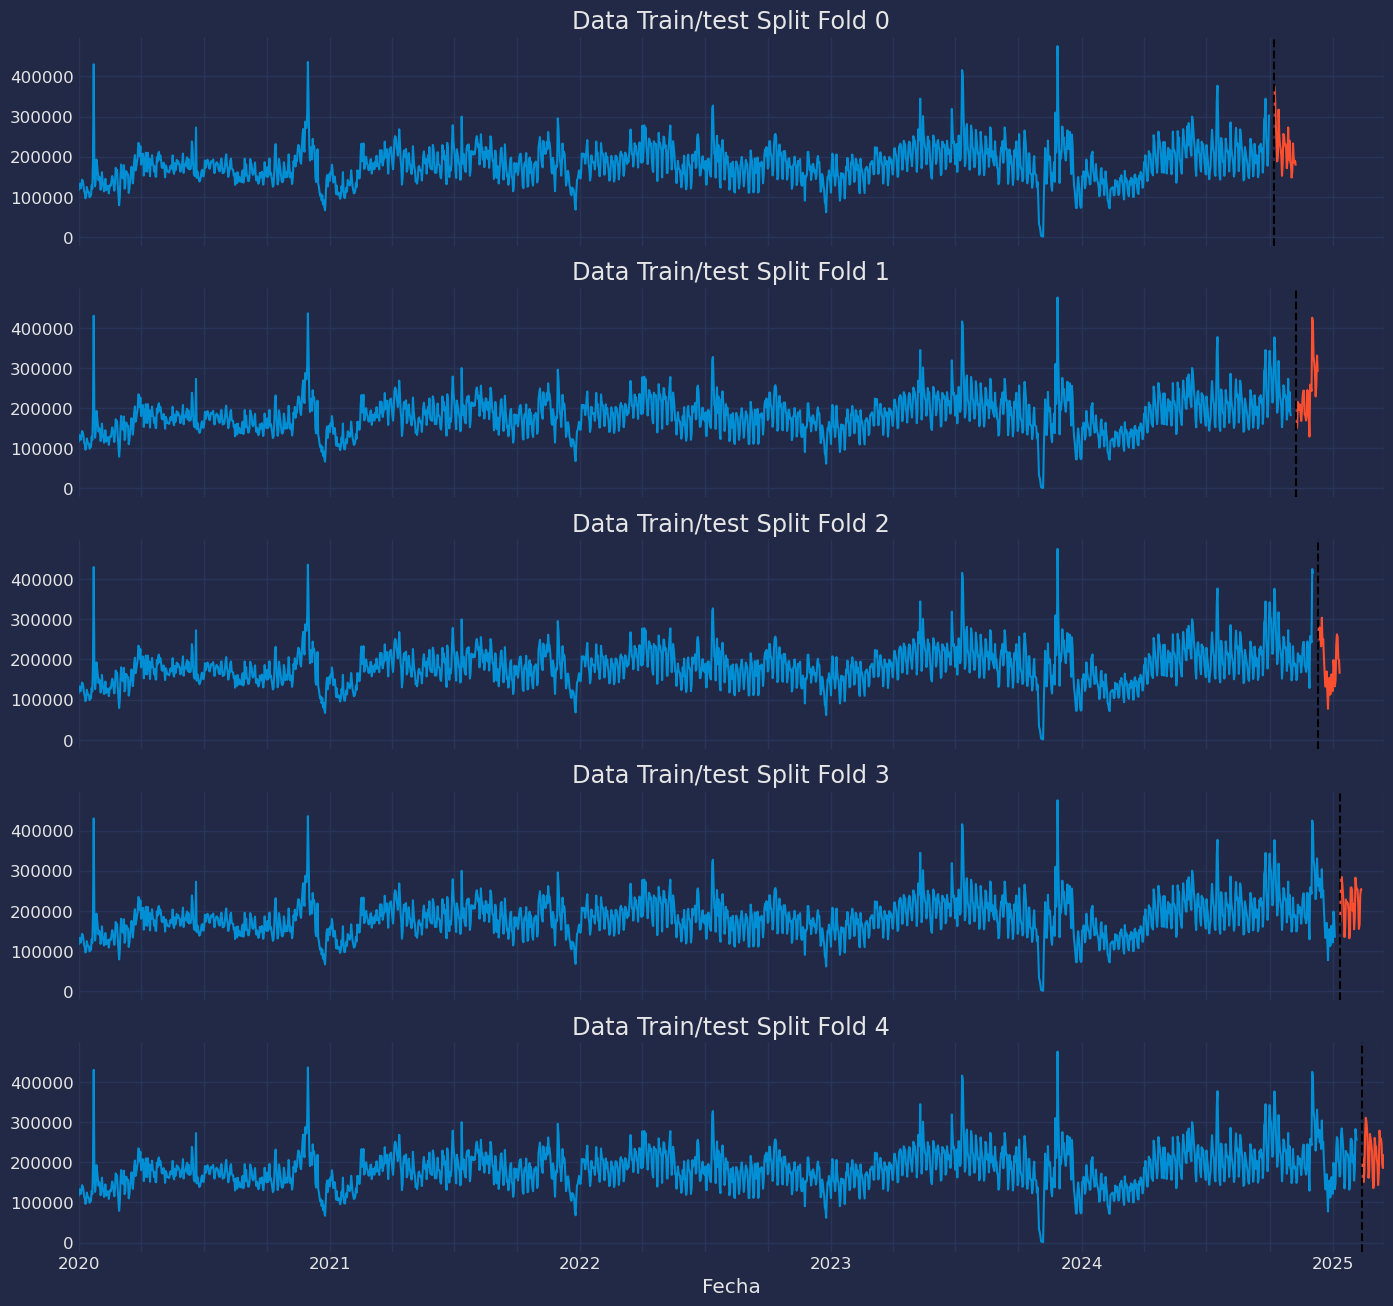

In [24]:
fig, axs = plt.subplots(5,1,figsize =(15,15), sharex=True)
fold = 0

for train_idx, val_idx in tss.split(ventas):
    train_1 = ventas.iloc[train_idx]
    test_1 = ventas.iloc[val_idx]
    train_1['Total'].plot(ax=axs[fold], 
                          label = 'Training Set',
                          title = f'Data Train/test Split Fold {fold}')
    test_1['Total'].plot(ax=axs[fold], 
                          label = 'Test Set')
    axs[fold].axvline(test_1.index.min(), color ='black', ls='--')
    fold +=1
plt.show()

In [25]:
ventas = create_feature(ventas)
ventas = add_lags(ventas)

ventas['lag1'].fillna(0, inplace=True)
ventas['lag2'].fillna(0, inplace=True)
ventas['lag3'].fillna(0, inplace=True)

In [26]:
### Entrenamiento

tss = TimeSeriesSplit(n_splits=5, test_size= 16, gap =7)
ventas = ventas.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(ventas):
    train_1 = ventas.iloc[train_idx]
    test_1 = ventas.iloc[val_idx]

    train_1 = create_feature(train_1)
    test_1 = create_feature(test_1)

    Feature = ['Año', 'Mes', 'Dia', 'Dia_de_la_Semana', 'Trimestre',
       'semana_del_año', 'Dia_del_año','lag1','lag2','lag3']
    Target = 'Total'

    X_train = train_1[Feature]
    y_train = train_1[Target]

    X_test = test_1[Feature]
    y_test = test_1[Target]

    X_train = X_train.astype(float)
    y_train = y_train.astype(float)
    X_test = X_test.astype(float)
    y_test = y_test.astype(float)

    
reg_2 = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', n_estimators = 1000, 
                        early_stopping_rounds = 50, objective = 'reg:linear', 
                        max_depth = 3, learning_rate = 0.1)

reg_2.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

xgb_predictions_sales = reg_2.predict(X_test)
preds.append(xgb_predictions_sales)
score = np.sqrt(mean_squared_error(y_test, xgb_predictions_sales))
scores.append(score)

[11:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:171925.38320	validation_1-rmse:198170.23583
[100]	validation_0-rmse:27395.76935	validation_1-rmse:22106.51266
[136]	validation_0-rmse:25368.64833	validation_1-rmse:24302.03705


In [27]:
xgb_predictions_sales

array([165703.95, 175716.34, 270707.7 , 250832.34, 234337.67, 227176.27,
       209070.98, 173042.8 , 173027.48, 258504.66, 266338.7 , 242790.4 ,
       233343.73, 196158.78, 167326.9 , 169811.27], dtype=float32)

In [28]:
### Predicting the future
ventas = create_feature(ventas)

Feature = ['Año', 'Mes', 'Dia', 'Dia_de_la_Semana', 'Trimestre',
       'semana_del_año', 'Dia_del_año','lag1','lag2','lag3']
Target = 'Total'

X_all = ventas[Feature]
y_all = ventas[Target]


reg_2 = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', n_estimators = 500, 
                        early_stopping_rounds = 50, objective = 'reg:linear', 
                        max_depth = 3, learning_rate = 0.1)

reg_2.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[11:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:171925.38320	validation_1-rmse:198170.23583
[100]	validation_0-rmse:27395.76935	validation_1-rmse:22106.51266
[136]	validation_0-rmse:25368.64833	validation_1-rmse:24302.03705


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [29]:
future_sales = pd.date_range('2025-03-17','2025-04-06', freq='1D')
future_df_sales = pd.DataFrame(index=future_sales)
future_df_sales['isFuture'] = True
ventas['isFuture'] = False
df_and_future_sales = pd.concat([ventas, future_df_sales])
df_and_future_sales = create_feature(df_and_future_sales)
df_and_future_sales = add_lags(df_and_future_sales)

In [30]:
future_w_feature_sales =df_and_future_sales.query('isFuture').copy()

In [31]:
future_w_feature_sales['sales_pred']= reg_2.predict(future_w_feature_sales[Feature].astype(float))

In [32]:
fig = px.line(future_w_feature_sales, x=future_w_feature_sales.index, y ='sales_pred', template='plotly_dark', title='Predicciones con el modelo de XGBoost')
fig.show()

In [33]:
future_w_feature['Sales_Pred'] = future_w_feature_sales['sales_pred']

predicciones_xgboost = pd.DataFrame(index=future_w_feature.index)
predicciones_xgboost['Refunds'] = future_w_feature['refunds_pred']
predicciones_xgboost['Sales'] = future_w_feature['Sales_Pred']
print(predicciones_xgboost.head())
predicciones_xgboost.to_excel('predicciones xgboost.xlsx', index=True)

                 Refunds          Sales
2025-03-17   9226.793945  258638.281250
2025-03-18  16903.173828  255620.453125
2025-03-19  10003.185547  228278.734375
2025-03-20  10583.798828  219311.828125
2025-03-21  10144.034180  201926.296875


In [34]:
refunds2.tail()

,Total,Año,Mes,Dia,Dia_de_la_Semana,Trimestre,semana_del_año,Dia_del_año,lag1,lag2,lag3,isFuture
Fecha,,,,,,,,,,,,
2025-03-12,9847.76,2025,3,12,2,1,11,71,4469.93,17344.18,10188.92,False
2025-03-13,7609.64,2025,3,13,3,1,11,72,1167.22,9178.43,6489.20,False
2025-03-14,8438.36,2025,3,14,4,1,11,73,10836.20,9382.72,2092.97,False
2025-03-15,4232.92,2025,3,15,5,1,11,74,24271.03,12292.95,14827.47,False
2025-03-16,1206.46,2025,3,16,6,1,11,75,9361.96,4838.87,15216.88,False


In [35]:
import plotly.express as px

historia_refunds = refunds2.tail(31)

fig_refunds = px.line(historia_refunds, x=historia_refunds.index, y='Total', template='plotly_dark', title='Historial de Refunds y Predicciones')
fig_refunds.add_trace(go.Scatter(x=future_w_feature.index, y=future_w_feature['refunds_pred'], mode='lines', name='Refunds Predicciones'))

fig_refunds.update_layout(xaxis_title='Fecha', yaxis_title='Refunds', legend_title='Leyenda')

# Mostrar el gráfico
fig_refunds.show()

historia_ventas = ventas.tail(31)

# Crear gráfico para ventas con datos históricos
fig_ventas = px.line(historia_ventas, x=historia_ventas.index, y='Total', template='plotly_dark', title='Historial de Ventas y Predicciones')
fig_ventas.add_trace(go.Scatter(x=future_w_feature.index, y=future_w_feature['Sales_Pred'], mode='lines', name='Ventas Predicciones'))

# Personalizar diseño
fig_ventas.update_layout(xaxis_title='Fecha', yaxis_title='Ventas', legend_title='Leyenda')

# Mostrar el gráfico
fig_ventas.show()

